In [35]:
# Importation des librairies
# ================================
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from itertools import cycle


In [36]:
# ================================
# 2. Chargement du dataset
# ================================
df = pd.read_csv('C:\\Users\\Elvis\\Downloads\\DATA.csv', sep=';')
df.columns = df.columns.str.strip()  # Nettoyage des noms de colonnes
df.dropna(inplace=True)  # Suppression valeurs manquantes

# Renommage colonnes
df.rename(columns={
    'Temperature': 'temperature',
    'Humidity': 'humidity',
    'Tension': 'tension',
    'Energy Consumption': 'energy_consumption',
    'External Temp': 'external_temp'
}, inplace=True)

# Conversion en float
for column in ['temperature', 'humidity', 'tension', 'energy_consumption', 'external_temp']:
    df[column] = df[column].replace(',', '.', regex=True).astype(float)

# Encodage cible avec remplacement demandé
df['failure_type_encoded'] = df['failure_type'].replace({
    'Fonctionnement normal': 0,
    'Panne thermostat': 1,         
    'Panne compresseur': 2,
    'Panne ventilateur': 3,
    'Arret fonctionnement': 4,
    'Temperature trop haute': 5,
    'Humidite trop basse': 6
})

df.head()


,temperature,humidity,tension,energy_consumption,external_temp,failure_type,failure_type_encoded
0,3.0,61.2,223.0,2.50,29.50,Fonctionnement normal,0
1,-5.0,64.4,225.0,3.40,29.44,Panne thermostat,1
2,24.0,64.9,110.0,4.60,29.50,Panne compresseur,2
3,19.0,87.0,222.0,2.28,29.50,Panne ventilateur,3
4,14.0,74.0,224.0,2.27,29.50,Temperature trop haute,5


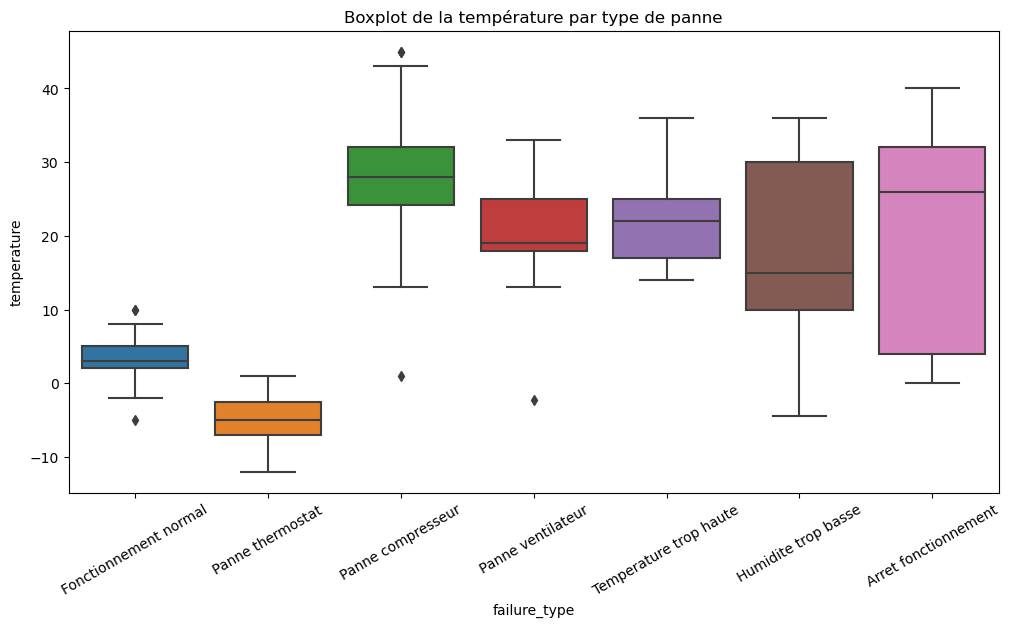

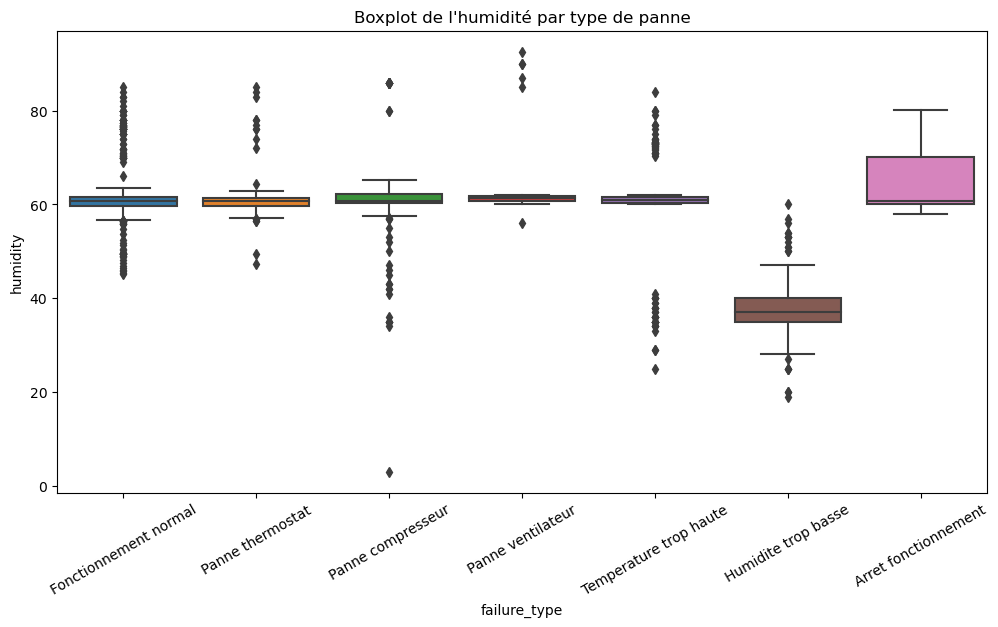

In [37]:
# ================================
# 3. Exploration visuelle (Boxplots)
# ================================
plt.figure(figsize=(12,6))
sns.boxplot(x="failure_type", y="temperature", data=df)
plt.title("Boxplot de la température par type de panne")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x="failure_type", y="humidity", data=df)
plt.title("Boxplot de l'humidité par type de panne")
plt.xticks(rotation=30)
plt.show()


In [38]:
# ================================
# 4. Normalisation des données
# ================================
scaler = StandardScaler()
df[['temperature', 'humidity', 'tension', 'energy_consumption', 'external_temp']] = scaler.fit_transform(
    df[['temperature', 'humidity', 'tension', 'energy_consumption', 'external_temp']]
)


In [39]:
# ================================
# 5. Préparation des données
# ================================
def data_preparation(df, target_name):
    X = df.drop(columns=[target_name, 'failure_type_encoded'])
    y = df['failure_type_encoded'].astype(int)  # 

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, train_size=0.7, stratify=y_res, random_state=0
    )
    return X_res, y_res, X_train, X_test, y_train, y_test


In [40]:
# ================================
# 6. Définition des modèles
# ================================
xgb_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=7, 
    random_state=0, 
    reg_lambda=1.0,  
    reg_alpha=0.5  
)

rf_model = RandomForestClassifier(
    n_estimators=30,
    max_depth=6,
    max_features=0.48,
    min_samples_split=12,
    min_samples_leaf=5,
    bootstrap=False,
    class_weight="balanced",
    random_state=0
)


In [41]:
# ================================
# 7. Entraînement et Prédiction
# ================================
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")


XGBoost Accuracy: 0.9688
Random Forest Accuracy: 0.9485


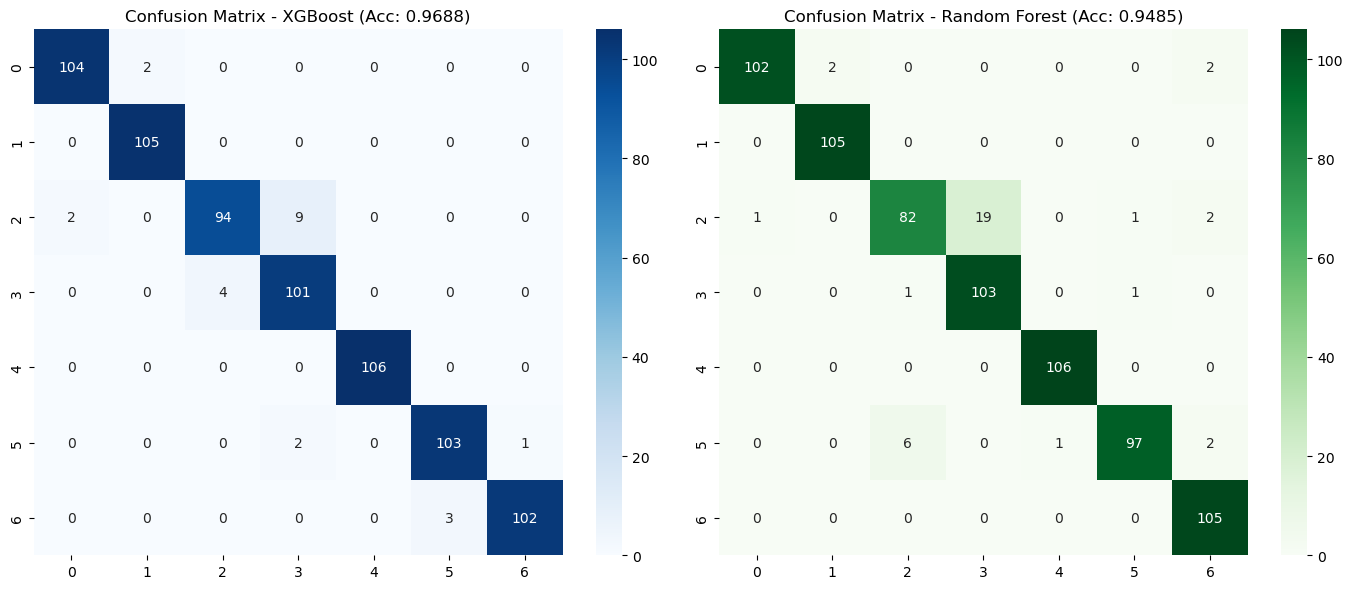

In [42]:
# ================================
# 9. Matrices de confusion
# ================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Confusion Matrix - XGBoost (Acc: {accuracy_xgb:.4f})')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Confusion Matrix - Random Forest (Acc: {accuracy_rf:.4f})')

plt.tight_layout()
plt.show()


In [43]:
from sklearn.metrics import classification_report
import pandas as pd

# ================================
# Rapport de classification détaillé
# ================================
report_xgb = classification_report(y_test, y_pred_xgb, target_names=[
    "Normal", "Panne thermostat", "Panne compresseur", "Panne ventilateur",
    "Arrêt fonctionnement", "Température trop haute", "Humidité trop basse"
], output_dict=True)

report_rf = classification_report(y_test, y_pred_rf, target_names=[
    "Normal", "Panne thermostat", "Panne compresseur", "Panne ventilateur",
    "Arrêt fonctionnement", "Température trop haute", "Humidité trop basse"
], output_dict=True)

df_xgb = pd.DataFrame(report_xgb).transpose().round(2)
df_rf = pd.DataFrame(report_rf).transpose().round(2)

print("\n--- Performances XGBoost ---\n")
print(df_xgb)

print("\n--- Performances Random Forest ---\n")
print(df_rf)



--- Performances XGBoost ---

                        precision  recall  f1-score  support
Normal                       0.98    0.98      0.98   106.00
Panne thermostat             0.98    1.00      0.99   105.00
Panne compresseur            0.96    0.90      0.93   105.00
Panne ventilateur            0.90    0.96      0.93   105.00
Arrêt fonctionnement         1.00    1.00      1.00   106.00
Température trop haute       0.97    0.97      0.97   106.00
Humidité trop basse          0.99    0.97      0.98   105.00
accuracy                     0.97    0.97      0.97     0.97
macro avg                    0.97    0.97      0.97   738.00
weighted avg                 0.97    0.97      0.97   738.00

--- Performances Random Forest ---

                        precision  recall  f1-score  support
Normal                       0.99    0.96      0.98   106.00
Panne thermostat             0.98    1.00      0.99   105.00
Panne compresseur            0.92    0.78      0.85   105.00
Panne ventilateur

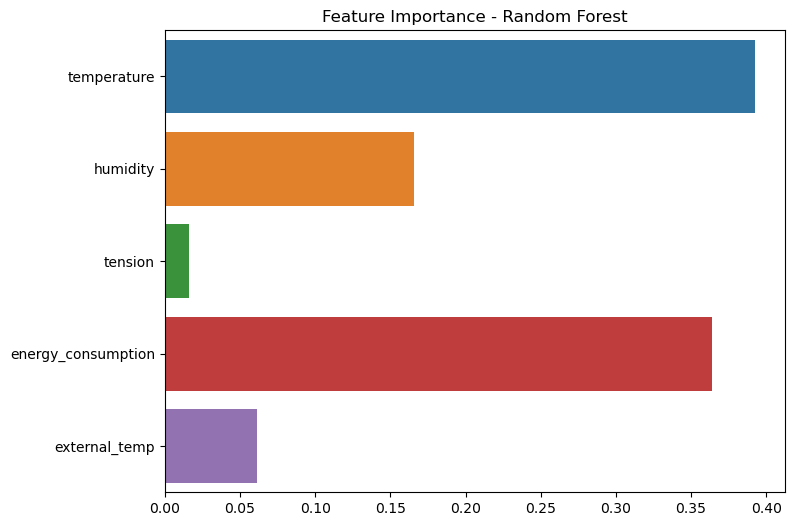

<Figure size 800x600 with 0 Axes>

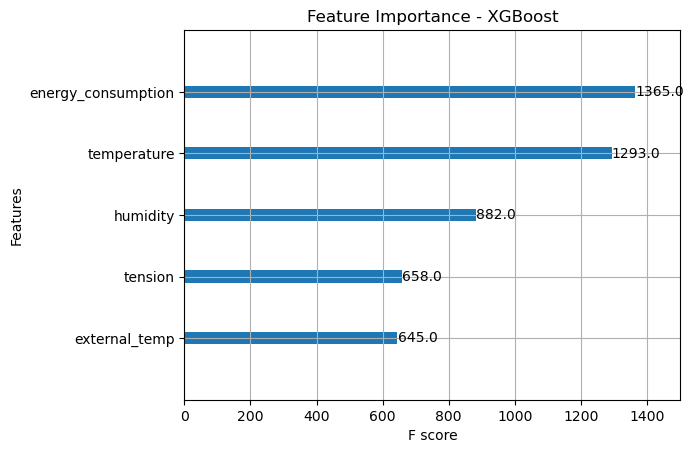

In [44]:
# ================================
# 11. Feature Importance
# ================================
# Random Forest
plt.figure(figsize=(8,6))
sns.barplot(x=rf_model.feature_importances_, y=X_train.columns)
plt.title("Feature Importance - Random Forest")
plt.show()

# XGBoost
plt.figure(figsize=(8,6))
plot_importance(xgb_model, importance_type="weight", max_num_features=10)
plt.title("Feature Importance - XGBoost")
plt.show()